# Chinese fund analysis with a trial of price down/up predictor

### preparations 
- utils is custom lib for operate data
- models is the model class of db.
- config is at config.json
- data_operator is data operating class
- can also direct run strategy file by write the strategy path in config.json

In [1]:
import pandas as pd
import os, sys
sys.path.append("..")
from utils.getfund import data_operator
import pandas as pd
from utils.operatefund import Operator, User
from models.models import db_operator
from utils.readconfig import config
import datetime
from multiprocessing import Process, Queue, Pool
# from strategies.fixed import Strategy
# exec("from strategies.{} import Strategy".format(config["strategy_file"]))
from concurrent.futures import ThreadPoolExecutor
from strategies.fixed import Strategy
import datetime
import cupy as cp
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

------------------ F:\Projects\pricepredictor\data\db\MyFund.db
------------- sqlite:///F:\Projects\pricepredictor\data\db\MyFund.db?check_same_thread=False
2020-07-20 02:03:18,724 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-20 02:03:18,725 INFO sqlalchemy.engine.base.Engine ()
2020-07-20 02:03:18,726 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-20 02:03:18,727 INFO sqlalchemy.engine.base.Engine ()
2020-07-20 02:03:18,728 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Fund")
2020-07-20 02:03:18,728 INFO sqlalchemy.engine.base.Engine ()
2020-07-20 02:03:18,731 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Record")
2020-07-20 02:03:18,731 INFO sqlalchemy.engine.base.Engine ()
2020-07-20 02:03:18,732 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("User")
2020-07-20 02:03:18,733 INFO sqlalchemy.engine.base.Engine ()
2020-07-20 02:03:18,735

### read all fund data from db
- all_fund.csv contains the fund code list
- db file can be set in config.json

In [2]:
fund_list_all = data_operator.get_funds_list("F:\\Projects\\pricepredictor\\data\\fund_data\\all_fund.csv")
fund_code_list = fund_list_all.ID.values
fd_data = data_operator.load_funds(fund_code_list)
print(len(fd_data.sort_values(by="date")))

6123682


In [3]:
# select the funds with 8 years' history.
# fund with long history means more stability.
long_fd_list = fd_data[fd_data.date>datetime.datetime(2020,2,1)].fund_code.unique()
long_fd_list1 = fd_data[fd_data.date<datetime.datetime(2012,2,1)].fund_code.unique()
long_fd_list

array(['000001', '000003', '000004', ..., '519953', '519955', '007115'],
      dtype=object)

### filter the fund longer than 8 years

In [4]:
import numpy as np
len(long_fd_list)
len(long_fd_list1)
len(np.intersect1d(long_fd_list,long_fd_list1))
long_fd_list = np.intersect1d(long_fd_list,long_fd_list1)
print(len(long_fd_list))
long_fd_list[100:200]

709


array(['092002', '096001', '100020', '100022', '100026', '100032',
       '100037', '100038', '100039', '100050', '100051', '100053',
       '100055', '100056', '100058', '110001', '110002', '110003',
       '110005', '110007', '110008', '110009', '110011', '110012',
       '110013', '110015', '110017', '110018', '110019', '110020',
       '110021', '110022', '110023', '110026', '110028', '110035',
       '110036', '112002', '121001', '121002', '121003', '121005',
       '121006', '121008', '121009', '121012', '128112', '151001',
       '151002', '160105', '160119', '160121', '160123', '160124',
       '160125', '160211', '160212', '160213', '160215', '160217',
       '160311', '160314', '160513', '160514', '160603', '160605',
       '160607', '160610', '160611', '160612', '160613', '160615',
       '160616', '160617', '160618', '160706', '160716', '160717',
       '160718', '160719', '160805', '160806', '160807', '160808',
       '160910', '161005', '161010', '161014', '161015', '1611

### deal with miss value/default value
- miss value is filled with the former non-default value
- take fund '110013' code to analyze

In [5]:
# take '110013' as example
class code_config(object):
    target_code = '110013'
    train_dur = [datetime.date(2012,3,1), datetime.date(2016,3,1)]
    test_dur = [datetime.date(2016,3,2), datetime.date(2017,3,2)]

target_fund = fd_data[fd_data.fund_code==code_config.target_code]
target_fund.isna()

,fund_code,date,price,accumulate,daily_rate,purchase_state,ransom_state,dividends
124,False,False,False,False,False,False,False,False
835,False,False,False,False,False,False,False,False
1548,False,False,False,False,False,False,False,False
2260,False,False,False,False,False,False,False,False
2981,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
6095079,False,False,False,False,False,False,False,False
6102148,False,False,False,False,False,False,False,False
6108822,False,False,False,False,False,False,False,False
6115420,False,False,False,False,False,False,False,False


### check the default value
- no default/miss value remains

In [6]:
# make sure missed value inside.
# for most fund, default is processed/filterred when scrapping
target_fund[target_fund.isna().values==False]
for x in target_fund.columns:
    print(target_fund[x][target_fund[x].isna()==True],'missed')

Series([], Name: fund_code, dtype: object) missed
Series([], Name: date, dtype: datetime64[ns]) missed
Series([], Name: price, dtype: float64) missed
Series([], Name: accumulate, dtype: float64) missed
Series([], Name: daily_rate, dtype: float64) missed
Series([], Name: purchase_state, dtype: object) missed
Series([], Name: ransom_state, dtype: object) missed
Series([], Name: dividends, dtype: object) missed


### deal with time-sequencial data
- to better take use of time tag, time sequence is turned to Q1, Q2, Q3, Q4.
- split features to numeric features & category features.

In [7]:
# analyzing features
# fund_date could be cut into seasons (Q1, Q2, Q3, Q4)
# numeric type: price, accumulate, daily_rate
# category type: purchase_state, ransom_state, dividends
target_fund.head(10)

,fund_code,date,price,accumulate,daily_rate,purchase_state,ransom_state,dividends
124,110013,2012-01-31,1.050,5.009,0.0086,开放申购,开放赎回,
835,110013,2012-02-01,1.040,4.996,-0.0095,开放申购,开放赎回,
1548,110013,2012-02-02,1.056,5.017,0.0154,开放申购,开放赎回,
2260,110013,2012-02-03,1.065,5.029,0.0085,开放申购,开放赎回,
2981,110013,2012-02-06,1.057,5.018,-0.0075,开放申购,开放赎回,
3692,110013,2012-02-07,1.042,4.998,-0.0142,开放申购,开放赎回,
4403,110013,2012-02-08,1.063,5.026,0.0202,开放申购,开放赎回,
5114,110013,2012-02-09,1.075,5.042,0.0113,开放申购,开放赎回,
5826,110013,2012-02-10,1.088,5.060,0.0121,开放申购,开放赎回,
6547,110013,2012-02-13,1.074,5.041,-0.0129,开放申购,开放赎回,


### observe numeric variables/features.

In [8]:
# for numeric types
target_fund.describe()

,price,accumulate,daily_rate
count,2060.000000,2060.000000,2060.000000
mean,2.099930,6.729024,0.000969
std,0.740384,1.189568,0.016686
min,0.991000,4.930000,-0.076300
25%,1.314750,5.431750,-0.007300
50%,2.245000,7.014500,0.000900
75%,2.620250,7.562250,0.009700
max,4.369000,10.196000,0.069300


### distribution of variables

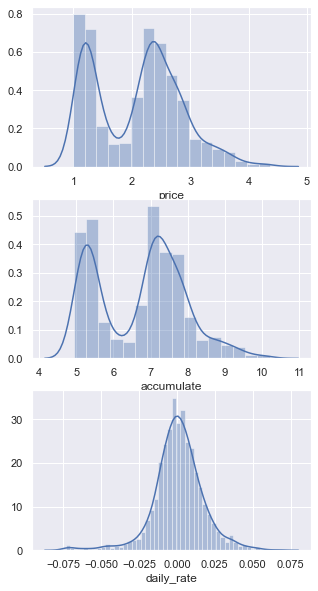

In [9]:
# check the distribution
sns.set(style='darkgrid')
plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
sns.distplot(target_fund['price'])
plt.subplot(312)
sns.distplot(target_fund['accumulate'])
plt.subplot(313)
sns.distplot(target_fund['daily_rate'])
# it seems that daily_rate is obeying the normal distribution.

### Observe the extreme value of numeric features.

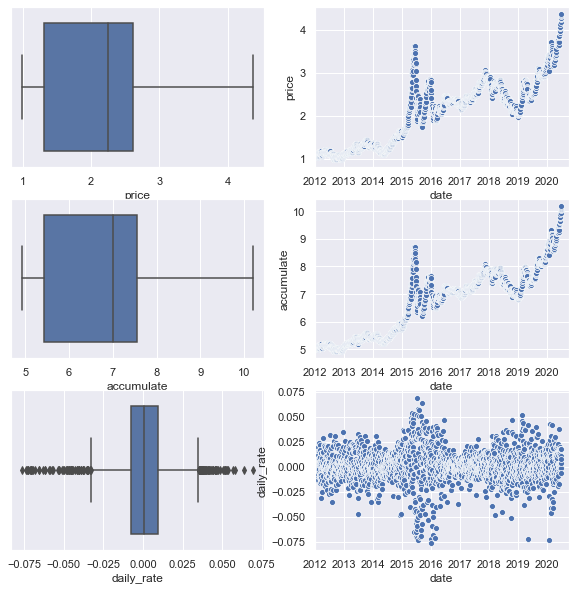

In [10]:
# about extreme values
sns.set(style='darkgrid')
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.boxplot(target_fund['price'])
plt.subplot(323)
sns.boxplot(target_fund['accumulate'])
plt.subplot(325)
sns.boxplot(target_fund['daily_rate'])
ax = plt.subplot(322)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x='date', y='price')
ax = plt.subplot(324)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x = 'date', y='accumulate')
ax = plt.subplot(326)
ax.set_xlim([datetime.datetime(2012,1,1),datetime.datetime(2020,10,1)])
sns.scatterplot(data = target_fund, x = 'date', y='daily_rate')
# extreme value is not ridiculious. no need to cut.

### deal with category features
- ransom --> only one type, no need
- purchase_state --> turn to one-hot(0/1)
- dividends --> contains number, and need to turn to value

- turn dividends to numbers

In [11]:
# for category variables, check all types
print(target_fund.purchase_state.unique(),'# purchase_state','\n')
print(target_fund.ransom_state.unique(),'# ransom_state','\n')
print(target_fund.dividends.unique(),'# dividends','\n' )


['开放申购' '限制大额申购'] # purchase_state 

['开放赎回'] # ransom_state 

['' '每份派现金0.0400元' '每份派现金0.0600元' '每份派现金0.0800元' '每份派现金0.1040元'
 '每份派现金0.1170元' '每份派现金0.0100元'] # dividends 



### start to feature engineering
- data preprocessing
- turn index to date
- delete ransom_state (fixed data)

In [12]:

raw_target_data = target_fund
raw_target_data.set_index(raw_target_data.date, inplace=True)
raw_target_data = raw_target_data[['price','accumulate','daily_rate','purchase_state','dividends']]
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends
date,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,
2012-02-01,1.040,4.996,-0.0095,开放申购,
2012-02-02,1.056,5.017,0.0154,开放申购,
2012-02-03,1.065,5.029,0.0085,开放申购,
2012-02-06,1.057,5.018,-0.0075,开放申购,
...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,
2020-06-30,4.345,10.164,0.0178,开放申购,
2020-07-01,4.318,10.127,-0.0062,开放申购,


In [13]:
# extract price to 
# turn time to quarter: month->quarter
# Q1->[1,2,3], Q2->[4,5,6], Q3->[7,8,9], Q4->[10,11,12]
import math
timemap = {i:math.ceil(i/3) for i in range(1,13)}
raw_target_data["quarter"] = raw_target_data.apply(lambda x: timemap[x.name.month], axis=1)
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends,quarter
date,,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,,1
2012-02-01,1.040,4.996,-0.0095,开放申购,,1
2012-02-02,1.056,5.017,0.0154,开放申购,,1
2012-02-03,1.065,5.029,0.0085,开放申购,,1
2012-02-06,1.057,5.018,-0.0075,开放申购,,1
...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,,2
2020-06-30,4.345,10.164,0.0178,开放申购,,2
2020-07-01,4.318,10.127,-0.0062,开放申购,,3


In [14]:
# extract numeric data from [dividends]
raw_target_data.dividends = pd.to_numeric(raw_target_data['dividends'].apply(lambda x: x[5:-1])).fillna(0)
raw_target_data

,price,accumulate,daily_rate,purchase_state,dividends,quarter
date,,,,,,
2012-01-31,1.050,5.009,0.0086,开放申购,0.0,1
2012-02-01,1.040,4.996,-0.0095,开放申购,0.0,1
2012-02-02,1.056,5.017,0.0154,开放申购,0.0,1
2012-02-03,1.065,5.029,0.0085,开放申购,0.0,1
2012-02-06,1.057,5.018,-0.0075,开放申购,0.0,1
...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,开放申购,0.0,2
2020-06-30,4.345,10.164,0.0178,开放申购,0.0,2
2020-07-01,4.318,10.127,-0.0062,开放申购,0.0,3


### Normalization of data
- turn category to one-hot
- scaling the numeric features

In [15]:
# transform [purchase_state] and [quarter] to one-hot
purchase_state_map = {'开放申购':1, '限制大额申购':2}
raw_target_data['purchase_state']=raw_target_data['purchase_state'].apply(lambda x: purchase_state_map[x])
new_target_data = pd.get_dummies(raw_target_data, columns=['purchase_state', 'quarter'])
new_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,1.050,5.009,0.0086,0.0,1,0,1,0,0,0
2012-02-01,1.040,4.996,-0.0095,0.0,1,0,1,0,0,0
2012-02-02,1.056,5.017,0.0154,0.0,1,0,1,0,0,0
2012-02-03,1.065,5.029,0.0085,0.0,1,0,1,0,0,0
2012-02-06,1.057,5.018,-0.0075,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,0.0,1,0,0,1,0,0
2020-06-30,4.345,10.164,0.0178,0.0,1,0,0,1,0,0
2020-07-01,4.318,10.127,-0.0062,0.0,1,0,0,0,1,0


In [16]:
raw_target_data = new_target_data
raw_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,1.050,5.009,0.0086,0.0,1,0,1,0,0,0
2012-02-01,1.040,4.996,-0.0095,0.0,1,0,1,0,0,0
2012-02-02,1.056,5.017,0.0154,0.0,1,0,1,0,0,0
2012-02-03,1.065,5.029,0.0085,0.0,1,0,1,0,0,0
2012-02-06,1.057,5.018,-0.0075,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,4.269,10.062,-0.0009,0.0,1,0,0,1,0,0
2020-06-30,4.345,10.164,0.0178,0.0,1,0,0,1,0,0
2020-07-01,4.318,10.127,-0.0062,0.0,1,0,0,0,1,0


## Normalization of the price, accumulate, daily_rate, dividends.
### z-score + MaxMinScaler

In [17]:


def CustomEncoder(df=raw_target_data, columns=['price', 'accumulate','daily_rate','dividends']):
    scalers = dict()
    scalers['stand'] = dict()
    scalers['minmax'] = dict()
    temps = df[columns].copy()
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    for col in columns:
        scalers['stand'][col] = StandardScaler()
        scalers['minmax'][col] = MinMaxScaler()
        scalers['stand'][col].fit(df[[col]])
        temps[col] = scalers['stand'][col].transform(df[[col]])
        scalers['minmax'][col].fit(temps[[col]])
        temps[col] = scalers['minmax'][col].transform(temps[[col]])
    return temps[columns], scalers

        
def CustomDecoder(df, columns, scalers):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    temps = df[columns].copy()
    for col in columns:
        temps[col] = scalers['minmax'][col].inverse_transform(df[[col]])
        temps[col] = scalers['stand'][col].inverse_transform(temps[[col]])
    return temps

# test the custom encoder and custom decoder.
temp = raw_target_data.copy()
print(temp[['price', 'accumulate','daily_rate','dividends']],'\n # before encode')
temp[['price', 'accumulate','daily_rate','dividends']], scalers = CustomEncoder(temp,columns=['price', 'accumulate','daily_rate','dividends'])
print(temp,"\n # after encode")
temp[['price', 'accumulate','daily_rate','dividends']] = CustomDecoder(temp,columns = ['price', 'accumulate','daily_rate','dividends'],scalers=scalers)
print(temp[['price', 'accumulate','daily_rate','dividends']], '\n # after decode')

price  accumulate  daily_rate  dividends
date                                                
2012-01-31  1.050       5.009      0.0086        0.0
2012-02-01  1.040       4.996     -0.0095        0.0
2012-02-02  1.056       5.017      0.0154        0.0
2012-02-03  1.065       5.029      0.0085        0.0
2012-02-06  1.057       5.018     -0.0075        0.0
...           ...         ...         ...        ...
2020-06-29  4.269      10.062     -0.0009        0.0
2020-06-30  4.345      10.164      0.0178        0.0
2020-07-01  4.318      10.127     -0.0062        0.0
2020-07-02  4.334      10.149      0.0037        0.0
2020-07-03  4.369      10.196      0.0081        0.0

[2060 rows x 4 columns] 
 # before encode
               price  accumulate  daily_rate  dividends  purchase_state_1  \
date                                                                        
2012-01-31  0.017466    0.015002    0.583104        0.0                 1   
2012-02-01  0.014506    0.012533    0.458791     

In [18]:
# Normalization of raw_target_data
raw_target_data[['price', 'accumulate','daily_rate','dividends']], custom_scalers = CustomEncoder()

In [19]:
raw_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,0.017466,0.015002,0.583104,0.0,1,0,1,0,0,0
2012-02-01,0.014506,0.012533,0.458791,0.0,1,0,1,0,0,0
2012-02-02,0.019242,0.016521,0.629808,0.0,1,0,1,0,0,0
2012-02-03,0.021906,0.018800,0.582418,0.0,1,0,1,0,0,0
2012-02-06,0.019538,0.016711,0.472527,0.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-29,0.970397,0.974554,0.517857,0.0,1,0,0,1,0,0
2020-06-30,0.992895,0.993923,0.646291,0.0,1,0,0,1,0,0
2020-07-01,0.984902,0.986897,0.481456,0.0,1,0,0,0,1,0


### training data & verification data & test data
### input: timestep=30, features=[price	accumulate	daily_rate	dividends	purchase_state_1	purchase_state_2	quarter_1	quarter_2	quarter_3	quarter_4], output = [price] of 5 days later.
### train set: 2012-3-1-->2017-3-1
### verification set: 2017-3-1-->2018-3-1
### test set: 2018-3-1-->2020-3-1

In [20]:

shift_target_data = raw_target_data
shift_target_data['y'] = raw_target_data['price'].shift(-5)
shift_target_data

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4,y
date,,,,,,,,,,,
2012-01-31,0.017466,0.015002,0.583104,0.0,1,0,1,0,0,0,0.015098
2012-02-01,0.014506,0.012533,0.458791,0.0,1,0,1,0,0,0,0.021314
2012-02-02,0.019242,0.016521,0.629808,0.0,1,0,1,0,0,0,0.024867
2012-02-03,0.021906,0.018800,0.582418,0.0,1,0,1,0,0,0,0.028715
2012-02-06,0.019538,0.016711,0.472527,0.0,1,0,1,0,0,0,0.024571
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-29,0.970397,0.974554,0.517857,0.0,1,0,0,1,0,0,NaN
2020-06-30,0.992895,0.993923,0.646291,0.0,1,0,0,1,0,0,NaN
2020-07-01,0.984902,0.986897,0.481456,0.0,1,0,0,0,1,0,NaN


In [21]:
raw_train_y = shift_target_data['2012-04-01':'2017-03-01']['y']
raw_verify_y = shift_target_data['2017-3-1':'2018-03-01']['y']
raw_test_y = shift_target_data['2018-3-1':'2020-3-1']['y']

In [22]:
timestep = 20 # No data on Sunday and Saturday, therefore 20 days/month
temp_train_x = [] # holding the train data x
temp_verify_x = [] # holding the verify data x
temp_test_x = [] # holding the test data x
# input: data of past 30 days, output: price of 5 days later.

for x in raw_train_y.index:
    temp_train_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns[:-1]])

for x in raw_verify_y.index:
    temp_verify_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns[:-1]])

for x in raw_test_y.index:
    temp_test_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns[:-1]])

print(temp_train_x[0])
print(raw_train_y)
shift_target_data[45:54]

price  accumulate  daily_rate  dividends  purchase_state_1  \
date                                                                        
2012-03-06  0.045885    0.039499    0.447115        0.0                 1   
2012-03-07  0.043221    0.037220    0.469780        0.0                 1   
2012-03-08  0.048845    0.041967    0.638736        0.0                 1   
2012-03-09  0.052102    0.044816    0.589286        0.0                 1   
2012-03-12  0.049142    0.042157    0.464973        0.0                 1   
2012-03-13  0.053878    0.046335    0.618819        0.0                 1   
2012-03-14  0.042925    0.036840    0.307692        0.0                 1   
2012-03-15  0.038484    0.033042    0.433379        0.0                 1   
2012-03-16  0.043221    0.037220    0.622253        0.0                 1   
2012-03-19  0.043813    0.037600    0.536401        0.0                 1   
2012-03-20  0.039964    0.034371    0.445742        0.0                 1   
2012-03-21  0.

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4,y
date,,,,,,,,,,,
2012-04-05,0.036412,0.031333,0.720467,0.0,1,0,0,1,0,0,0.047661
2012-04-06,0.040853,0.035131,0.616758,0.0,1,0,0,1,0,0,0.047661
2012-04-09,0.037892,0.032472,0.462912,0.0,1,0,0,1,0,0,0.048845
2012-04-10,0.042333,0.036460,0.616071,0.0,1,0,0,1,0,0,0.042925
2012-04-11,0.042629,0.036650,0.530220,0.0,1,0,0,1,0,0,0.050326
2012-04-12,0.047661,0.041018,0.627060,0.0,1,0,0,1,0,0,0.049142
2012-04-13,0.047661,0.041018,0.524038,0.0,1,0,0,1,0,0,0.051510
2012-04-16,0.048845,0.041967,0.548077,0.0,1,0,0,1,0,0,0.046477
2012-04-17,0.042925,0.036840,0.405220,0.0,1,0,0,1,0,0,0.046773


In [23]:
train_x = [x.values for x in temp_train_x]
verify_x = [x.values for x in temp_verify_x]
test_x = [x.values for x in temp_test_x]
train_y = raw_train_y.values
verify_y = raw_verify_y.values
test_y = raw_verify_y.values

In [24]:
len(train_x[0][0])
len(temp_train_x[0].columns)
train_x[0].shape

(21, 10)

### building model--> LSTM regression

In [25]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
lstm_outputs = 50
time_steps = timestep+1
lstm_vector = train_x[0].shape[1]
LSTM_model = Sequential()
LSTM_model.add(LSTM(units = lstm_outputs, input_shape=(time_steps, lstm_vector),unroll=True,return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(units=lstm_outputs))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(units = 30, activation="linear"))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(units = 1))
LSTM_model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
LSTM_model.fit(np.array(train_x), train_y, epochs=200, batch_size=50)


97/1197 [==============================] - 1s 661us/step - loss: 0.0024 - accuracy: 8.3542e-04
Epoch 21/200
1197/1197 [==============================] - 1s 710us/step - loss: 0.0023 - accuracy: 8.3542e-04
Epoch 22/200
1197/1197 [==============================] - 1s 633us/step - loss: 0.0024 - accuracy: 8.3542e-04
Epoch 23/200
1197/1197 [==============================] - 1s 609us/step - loss: 0.0024 - accuracy: 8.3542e-04
Epoch 24/200
1197/1197 [==============================] - 1s 626us/step - loss: 0.0021 - accuracy: 8.3542e-04
Epoch 25/200
1197/1197 [==============================] - 1s 657us/step - loss: 0.0022 - accuracy: 8.3542e-04
Epoch 26/200
1197/1197 [==============================] - 1s 683us/step - loss: 0.0022 - accuracy: 8.3542e-04
Epoch 27/200
1197/1197 [==============================] - 1s 696us/step - loss: 0.0020 - accuracy: 8.3542e-04
Epoch 28/200
1197/1197 [==============================] - 1s 618us/step - loss: 0.0019 - accuracy: 8.3542e-04
Epoch 29/200
1197/1197 [=

### verification

In [26]:
# verification
LSTM_model.summary()
loss = LSTM_model.evaluate(np.array(verify_x), verify_y, batch_size=128)
print(loss)
# result is really not good...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 50)            12200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [27]:
raw_test_y

date
2018-03-01    0.507697
2018-03-02    0.525459
2018-03-05    0.537004
2018-03-06    0.531676
2018-03-07    0.518354
                ...   
2020-02-24    0.766430
2020-02-25    0.774423
2020-02-26    0.770278
2020-02-27    0.776199
2020-02-28    0.764654
Name: y, Length: 489, dtype: float64

### predict & comparation with original data

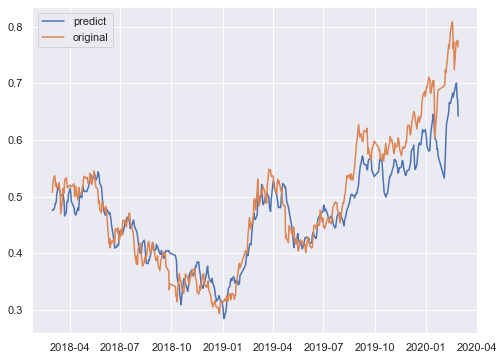

In [28]:

res = LSTM_model.predict(np.array(test_x))
res[:,0]
plt.figure(figsize=(8,6))
plt.plot(raw_test_y.index, res[:,0], label='predict')
plt.plot(raw_test_y.index, raw_test_y.values, label='original')
plt.legend()

In [29]:
# decode the price value
# temp = raw_target_data.copy()
# print(temp[['price', 'accumulate','daily_rate','dividends']],'\n # before encode')
# temp[['price', 'accumulate','daily_rate','dividends']], scalers = CustomEncoder(temp,columns=['price', 'accumulate','daily_rate','dividends'])
# print(temp,"\n # after encode")
# temp[['price', 'accumulate','daily_rate','dividends']] = CustomDecoder(temp,columns = ['price', 'accumulate','daily_rate','dividends'],scalers=scalers)
# print(temp[['price', 'accumulate','daily_rate','dividends']], '\n # after decode')
pred_price_decode = pd.DataFrame(res[:,0], index = raw_test_y.index, columns=['price'])
ori_price_decode = pd.DataFrame(raw_test_y.values, index = raw_test_y.index, columns=['price'])
pred_price_decode = CustomDecoder(pred_price_decode, columns=['price'], scalers=scalers)
ori_price_decode = CustomDecoder(ori_price_decode, columns=['price'], scalers=scalers)

In [30]:
 pred_price_decode['price']

date
2018-03-01    2.599224
2018-03-02    2.597979
2018-03-05    2.613081
2018-03-06    2.639302
2018-03-07    2.638558
                ...   
2020-02-24    3.349805
2020-02-25    3.357983
2020-02-26    3.267380
2020-02-27    3.259472
2020-02-28    3.160594
Name: price, Length: 489, dtype: float32

In [31]:
ori_price_decode['price'][-20:]

date
2020-02-03    3.340
2020-02-04    3.348
2020-02-05    3.438
2020-02-06    3.418
2020-02-07    3.449
2020-02-10    3.554
2020-02-11    3.587
2020-02-12    3.565
2020-02-13    3.624
2020-02-14    3.660
2020-02-17    3.722
2020-02-18    3.717
2020-02-19    3.563
2020-02-20    3.603
2020-02-21    3.437
2020-02-24    3.580
2020-02-25    3.607
2020-02-26    3.593
2020-02-27    3.613
2020-02-28    3.574
Name: price, dtype: float64

In [32]:
temp[temp.index<datetime.datetime(2020,3,2)]

,price,accumulate,daily_rate,dividends,purchase_state_1,purchase_state_2,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,
2012-01-31,1.050,5.009,0.0086,5.421011e-20,1,0,1,0,0,0
2012-02-01,1.040,4.996,-0.0095,5.421011e-20,1,0,1,0,0,0
2012-02-02,1.056,5.017,0.0154,5.421011e-20,1,0,1,0,0,0
2012-02-03,1.065,5.029,0.0085,5.421011e-20,1,0,1,0,0,0
2012-02-06,1.057,5.018,-0.0075,5.421011e-20,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-02-24,3.722,9.329,0.0169,5.421011e-20,1,0,1,0,0,0
2020-02-25,3.717,9.322,-0.0013,5.421011e-20,1,0,1,0,0,0
2020-02-26,3.563,9.116,-0.0414,5.421011e-20,1,0,1,0,0,0


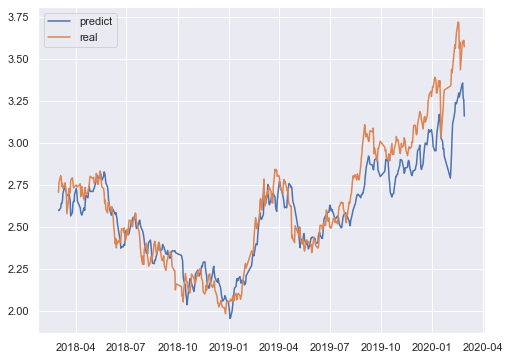

In [33]:
plt.figure(figsize=(8,6))
plt.plot(pred_price_decode.index, pred_price_decode['price'], label='predict')
plt.plot(ori_price_decode.index, ori_price_decode['price'], label='real')
plt.legend()
# decode to real price, seems to a bit slower than real price value

In [34]:
# it is hard to see if should buy or sell, should try turn value to categories
# turn regression to classification is better to see result.
# change the output from numeric to categories
timestep = 20 # No data on Sunday and Saturday, therefore 20 days/month
temp_train_x = [] # holding the train data x
temp_verify_x = [] # holding the verify data x
temp_test_x = [] # holding the test data x
cat_train_y = raw_train_y.copy()
cat_verify_y = raw_verify_y.copy()
cat_test_y = raw_test_y.copy()
for x in raw_train_y.index:
    temp_train_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns])
    cat_train_y[x] = 0 if (raw_train_y[x]-temp_train_x[-1]['price'].iloc[-1]) ==0 else (raw_train_y[x]-temp_train_x[-1]['price'].iloc[-1])/abs((raw_train_y[x]-temp_train_x[-1]['price'].iloc[-1]))
print(cat_train_y,"# cat_train_y")

for x in raw_verify_y.index:
    temp_verify_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns])
    cat_verify_y[x] = 0 if (raw_verify_y[x]-temp_verify_x[-1]['price'].iloc[-1]) ==0 else (raw_verify_y[x]-temp_verify_x[-1]['price'].iloc[-1])/abs((raw_verify_y[x]-temp_verify_x[-1]['price'].iloc[-1]))
print(cat_verify_y,"# cat_verify_y")

for x in raw_test_y.index:
    temp_test_x.append(shift_target_data.iloc[shift_target_data.index.get_loc(x)-timestep:shift_target_data.index.get_loc(x)+1][shift_target_data.columns])
    cat_test_y[x] = 0 if (raw_test_y[x]-temp_test_x[-1]['price'].iloc[-1]) ==0 else (raw_test_y[x]-temp_test_x[-1]['price'].iloc[-1])/abs((raw_test_y[x]-temp_test_x[-1]['price'].iloc[-1]))
print(cat_test_y,"# cat_test_y")

# 1 for grow up
# -1 for lower down
# 0 for holding

date
2012-04-05    1.0
2012-04-06    1.0
2012-04-09    1.0
2012-04-10    1.0
2012-04-11    1.0
             ... 
2017-02-23   -1.0
2017-02-24    1.0
2017-02-27    1.0
2017-02-28    1.0
2017-03-01    1.0
Name: y, Length: 1197, dtype: float64 # cat_train_y
date
2017-03-01    1.0
2017-03-02    1.0
2017-03-03    1.0
2017-03-06    1.0
2017-03-07    1.0
             ... 
2018-02-23    1.0
2018-02-26    1.0
2018-02-27    1.0
2018-02-28    1.0
2018-03-01    1.0
Name: y, Length: 247, dtype: float64 # cat_verify_y
date
2018-03-01    1.0
2018-03-02    1.0
2018-03-05    1.0
2018-03-06    1.0
2018-03-07    1.0
             ... 
2020-02-24   -1.0
2020-02-25   -1.0
2020-02-26    1.0
2020-02-27    1.0
2020-02-28    1.0
Name: y, Length: 489, dtype: float64 # cat_test_y


In [35]:
# turn y to one-hot coding
from sklearn.preprocessing import LabelBinarizer
oh_enc = LabelBinarizer()
oh_enc.fit(cat_train_y)
oh_cat_train_y = oh_enc.transform(cat_train_y)
oh_cat_test_y = oh_enc.transform(cat_test_y)
oh_cat_verify_y = oh_enc.transform(cat_verify_y)
oh_cat_test_y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [36]:
oh_cat_train_y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

### build a new model of classifier
#### input --> no change
#### output 
- -1 --> price down
- 0 --> price no change
- 1 --> price up

In [37]:


LSTM_classifier_1 = Sequential()
LSTM_classifier_1.add(LSTM(units=lstm_outputs,input_shape=(time_steps, lstm_vector),unroll=True,return_sequences=True))
LSTM_classifier_1.add(Dropout(0.2))
LSTM_classifier_1.add(LSTM(units=lstm_outputs))
LSTM_classifier_1.add(Dropout(0.2))
LSTM_classifier_1.add(Dense(units=lstm_outputs))
LSTM_classifier_1.add(Dropout(0.1))
LSTM_classifier_1.add(Dense(units=3, activation='softmax'))
LSTM_classifier_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

train_history_adam = LSTM_classifier_1.fit(np.array(train_x), oh_cat_train_y, epochs=500, batch_size=128)
# adam-->0.79
# rmsprop-->0.72
# sdg-->0.63
# bgd-->slow

/500
1197/1197 [==============================] - 0s 272us/step - loss: 0.4984 - accuracy: 0.7352
Epoch 315/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.4864 - accuracy: 0.7335
Epoch 316/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.5183 - accuracy: 0.7168
Epoch 317/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.5196 - accuracy: 0.7218
Epoch 318/500
1197/1197 [==============================] - 0s 268us/step - loss: 0.5357 - accuracy: 0.7201
Epoch 319/500
1197/1197 [==============================] - 0s 276us/step - loss: 0.5143 - accuracy: 0.7335
Epoch 320/500
1197/1197 [==============================] - 0s 270us/step - loss: 0.5119 - accuracy: 0.7285
Epoch 321/500
1197/1197 [==============================] - 0s 263us/step - loss: 0.4941 - accuracy: 0.7385
Epoch 322/500
1197/1197 [==============================] - 0s 272us/step - loss: 0.4938 - accuracy: 0.7260
Epoch 323/500
1197/1197 [=====================

In [38]:
LSTM_classifier_2 = Sequential()
LSTM_classifier_2.add(LSTM(units=lstm_outputs,input_shape=(time_steps, lstm_vector),unroll=True,return_sequences=True))
LSTM_classifier_2.add(Dropout(0.2))
LSTM_classifier_2.add(LSTM(units=lstm_outputs))
LSTM_classifier_2.add(Dropout(0.2))
LSTM_classifier_2.add(Dense(units=lstm_outputs))
LSTM_classifier_2.add(Dropout(0.1))
LSTM_classifier_2.add(Dense(units=3, activation='softmax'))
LSTM_classifier_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
train_history_rmsporp = LSTM_classifier_2.fit(np.array(train_x), oh_cat_train_y, epochs=500, batch_size=128)
# adam-->0.79
# rmsprop-->0.72
# sdg-->0.63
# bgd-->slow

/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.5533 - accuracy: 0.6951
Epoch 315/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.5561 - accuracy: 0.6951
Epoch 316/500
1197/1197 [==============================] - 0s 256us/step - loss: 0.5508 - accuracy: 0.6959
Epoch 317/500
1197/1197 [==============================] - 0s 282us/step - loss: 0.5415 - accuracy: 0.7034
Epoch 318/500
1197/1197 [==============================] - 0s 264us/step - loss: 0.5407 - accuracy: 0.7009
Epoch 319/500
1197/1197 [==============================] - 0s 279us/step - loss: 0.5426 - accuracy: 0.7068
Epoch 320/500
1197/1197 [==============================] - 0s 261us/step - loss: 0.5544 - accuracy: 0.7051
Epoch 321/500
1197/1197 [==============================] - 0s 261us/step - loss: 0.5606 - accuracy: 0.6876
Epoch 322/500
1197/1197 [==============================] - 0s 277us/step - loss: 0.5570 - accuracy: 0.6992
Epoch 323/500
1197/1197 [=====================

### performance comparsion of 2 optimizers

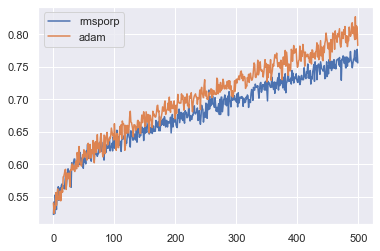

In [39]:
plt.plot(train_history_rmsporp.history['accuracy'], label = 'rmsporp')
plt.plot(train_history_adam.history['accuracy'], label='adam' )
plt.legend()
plt.show()

#### algorithm verification.

In [40]:
# evaluate the result:
loss, acc = LSTM_classifier_1.evaluate(np.array(verify_x), oh_cat_verify_y, batch_size = 128 )
print("LSTM_classifier_1: ",loss, acc)
loss, acc = LSTM_classifier_2.evaluate(np.array(verify_x), oh_cat_verify_y, batch_size = 128 )
print("LSTM_classifier_2: ",loss, acc)
# LSTM_classifier_1 a little overfitting.

247/247 [==============================] - 0s 1ms/step
LSTM_classifier_1:  3.222876513052566 0.4858299493789673
247/247 [==============================] - 0s 1ms/step
LSTM_classifier_2:  2.0121728234928145 0.5789473652839661


### model on test data

In [41]:
result_1 = LSTM_classifier_1.predict(np.array(test_x))
maxv = np.array([max(x) for x in result_1])
temp = []
for x in result_1:
    temp.append([])
    for y in x:
        if y==max(x):
            temp[-1].append(1)
        else:
            temp[-1].append(0)
result_1 = oh_enc.inverse_transform(np.array(temp))
real_test_y = oh_enc.inverse_transform(oh_cat_test_y)
_, accuracy = LSTM_classifier_1.evaluate(np.array(test_x), oh_cat_test_y)
print("accuracy: ", accuracy)

489/489 [==============================] - 0s 505us/step
accuracy:  0.4601227045059204


In [42]:
result_2 = LSTM_classifier_2.predict(np.array(test_x))
maxv = np.array([max(x) for x in result_2])
temp = []
for x in result_2:
    temp.append([])
    for y in x:
        if y==max(x):
            temp[-1].append(1)
        else:
            temp[-1].append(0)
result_2 = oh_enc.inverse_transform(np.array(temp))
real_test_y = oh_enc.inverse_transform(oh_cat_test_y)
_, accuracy = LSTM_classifier_2.evaluate(np.array(test_x), oh_cat_test_y)
print("accuracy: ", accuracy)

489/489 [==============================] - 0s 499us/step
accuracy:  0.4744376242160797


### create Boosting Tree

In [60]:
train_x_4_tree = [x.flatten() for x in train_x]
verify_x_4_tree = [x.flatten() for x in verify_x]
test_x_4_tree = [x.flatten() for x in test_x]

In [53]:

from sklearn.model_selection import GridSearchCV
parameters={
    'n_estimators':range(100,300,100),
    'max_depth':range(8,10,1),
    'learning_rate':[0.01, 0.05, 0.1],
    'min_child_weight':range(3,8,2),
    'subsample':[0.4,0.8,1],
    'gammaa':[0, 0.6, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'colsample_bylevel': [0.5,  0.8,  1]
}
from xgboost.sklearn import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
XGBoost_Classifier = XGBClassifier(n_estimators=100, max_depth=8,learning_rate=0.01, gamma=0, min_child_weight=3, subsample=0.85, colsample_bytree=0.7, colsample_bylevel=0.5 )
gsv = GridSearchCV(estimator=XGBoost_Classifier, param_grid=parameters, cv=3, refit=True, scoring='accuracy')
gsv.fit(np.array(train_x_4_tree), cat_train_y)
print("Best score: "gsv.best_score_)
print("Best parameters set: ")
best_parameters = gsv.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

TypeError: must be str, not numpy.float64

### Find the best superparameter by using cross verification.

In [56]:
print("Best score: ",gsv.best_score_)
print("Best parameters set: ")
best_parameters = gsv.best_estimator_.get_params()
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score:  0.5314679218967922
Best parameters set: 
	bootstrap: True
	ccp_alpha: 0.0
	class_weight: None
	criterion: 'gini'
	max_depth: 5
	max_features: 'auto'
	max_leaf_nodes: None
	max_samples: None
	min_impurity_decrease: 0.0
	min_impurity_split: None
	min_samples_leaf: 1
	min_samples_split: 3
	min_weight_fraction_leaf: 0.0
	n_estimators: 16
	n_jobs: None
	oob_score: False
	random_state: None
	verbose: 0
	warm_start: False


### Training the model with best superparameters.

In [70]:
XGBoost_Classifier = XGBClassifier(n_estimators=16, max_depth=5,learning_rate=0.01, gamma=0, min_child_weight=3)
XGBoost_Classifier.fit(np.array(train_x_4_tree), cat_train_y)
XGBoost_result = XGBoost_Classifier.predict(np.array(test_x_4_tree))
XGBoost_accuracy = sum((np.array(XGBoost_result)-cat_test_y.values)==0)/len(cat_test_y)
print("XGBoost accuracy on test data: ", XGBoost_accuracy)

XGBoost accuracy on test data:  0.5112474437627812


In [65]:
cat_test_y.values

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1

### create bagging trees (random forest) model

In [71]:
from sklearn.ensemble import RandomForestClassifier
random_forest_params = {
    'n_estimators':range(10, 20),
    'max_depth':range(5,12),
    'min_samples_split':range(1, 10)
}
Randomforest_Classifier = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=1)
gsv_randomfrst = GridSearchCV(estimator=Randomforest_Classifier, param_grid=random_forest_params, cv=5, refit=True, scoring='accuracy')
gsv_randomfrst.fit(np.array(train_x_4_tree), cat_train_y)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, min_samples_split=1,
                                              n_estimators=10),
             param_grid={'max_depth': range(5, 12),
                         'min_samples_split': range(1, 10),
                         'n_estimators': range(10, 20)},
             scoring='accuracy')

### find the best superparameters by cross verification.

In [72]:
print("Best score: ", gsv_randomfrst.best_score_)
print("Best parameters set: ")
random_best_parameters = gsv_randomfrst.best_estimator_.get_params()
for param_name in sorted(random_forest_params.keys()):
    print("\t%s: %r" % (param_name, random_best_parameters[param_name]))

Best score:  0.5214330543933053
Best parameters set: 
	max_depth: 7
	min_samples_split: 8
	n_estimators: 11


In [74]:
Randomforest_Classifier = RandomForestClassifier(n_estimators=11, max_depth=7, min_samples_split=8)
Randomforest_Classifier.fit(np.array(train_x_4_tree), cat_train_y)
randomFrst_result = Randomforest_Classifier.predict(np.array(test_x_4_tree))
randomFrst_accuracy = sum((np.array(randomFrst_result)-cat_test_y.values)==0)/len(cat_test_y)
print("random forest accuracy on test data: ", randomFrst_accuracy)

random forest accuracy on test data:  0.48466257668711654


### ensembling 3 models.
- LSTM classifier 1
- XGBoost tree
- Random forest tree

In [86]:
def vote_result(result_lst):
    import numpy as np
    voting_result = np.array([])
    for i in range(len(result_lst[0])):
        temp_lst = np.array([])
        for lst in result_lst:
            temp_lst = np.append(temp_lst,lst[i])
        nums = [np.sum(temp_lst==-1), np.sum(temp_lst==0),np.sum(temp_lst==1)]
        num = max(nums)
        if num == 1:
            voting_result = np.append(voting_result,0)
        else:
            voting_result = np.append(voting_result, nums.index(num)-1)
    return voting_result


# voting_result = np.around((result_1+randomFrst_result+XGBoost_result)/3)
voting_result = vote_result([result_1,randomFrst_result,XGBoost_result])
voting_accuracy = sum((np.array(voting_result)-cat_test_y.values)==0)/len(cat_test_y)
print("the voting result's accuracy on test data: ", voting_accuracy)

the voting result's accuracy on test data:  0.49079754601226994


# Conclusion:
- The result is rather random when using past 30 days price to predict future 5th day's price up/down.
- maybe longer time slot is better
- fundamental analysis could help more than simple price data.